In [95]:
import sys

required_libraries = ['owslib', 'localtileserver','requests','pandas','geopandas', 'matplotlib','seaborn','leafmap','pystac','pystac-client','planetary_computer','richdem','geocube']

missing_libraries = [lib for lib in required_libraries if lib not in sys.modules]

if missing_libraries:
    print("Installing missing libraries...")
    for lib in missing_libraries:
        !pip install {lib}

Installing missing libraries...
^C
^C


You should consider upgrading via the 'e:\edu\greg assignment\flood\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'e:\edu\greg assignment\flood\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'e:\edu\greg assignment\flood\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'e:\edu\greg assignment\flood\scripts\python.exe -m pip install --upgrade pip' command.



^C


You should consider upgrading via the 'e:\edu\greg assignment\flood\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'e:\edu\greg assignment\flood\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'e:\edu\greg assignment\flood\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'e:\edu\greg assignment\flood\scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import os
import io
import warnings
import zipfile
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import contextily as ctx
import matplotlib.pyplot as plt

from rasterio.transform import from_bounds, xy
from rasterio.io import MemoryFile
from shapely.geometry import Point, box
from owslib.wms import WebMapService
from PIL import Image as PILImage
from matplotlib.patches import Patch

warnings.simplefilter(action='ignore')

In [2]:
data_source = "https://data.eodms-sgdot.nrcan-rncan.gc.ca/public/EGS/2019/Flood/CAN/NB/Flood_CAN_NB_StJohn_20190427_222514.zip"
file_name = "Flood_CAN_NB_StJohn.zip"
response = requests.get(data_source, stream=True)

with open(file_name, "wb") as f:
    f.write(response.content)
    
extracted_folder = "Flood_Shapefile"
os.makedirs(extracted_folder, exist_ok=True)

with zipfile.ZipFile(file_name, "r") as zip_ref:
    zip_ref.extractall(extracted_folder)
    
shapefile_path = "Flood_Shapefile/Flood_CAN_NB_StJohn_20190427_222514.shp"
flood_df = gpd.read_file(shapefile_path)

In [3]:
flood_df.head()

class                        FEATURE_ID                             MD_ID  \
0      1  56a74cbadb8d4524941bd7f43f69b52b  d1b1d8a8fe48463aa8489b7798c46015   
1      2  1f347a2f4e87445180d7d843f0c40aea  466772ea732342aebd461886a2144d6d   
2      3  6fc76581c00f4002b38b8b6d89b4bc2b  164461d57ca345d5adb2f8f93f9f4dd7   

    AREA_HA    DATE_UTC  TIME_UTC       PERIM_M  \
0  70797.68  2019-04-27  22:25:14  4.644986e+06   
1  12696.88  2019-04-27  22:25:14  2.333779e+06   
2  21819.22  2019-04-27  22:25:14  3.755311e+06   

                                            geometry  
0  MULTIPOLYGON (((-66.06400 45.24707, -66.06347 ...  
1  MULTIPOLYGON (((-66.10235 45.23573, -66.10228 ...  
2  MULTIPOLYGON (((-66.10238 45.23576, -66.10236 ...

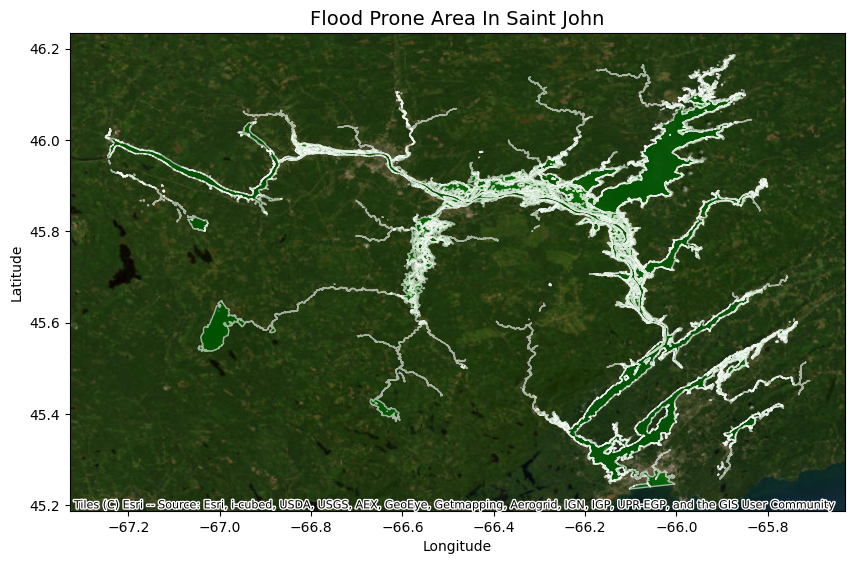

In [70]:
fig, ax = plt.subplots(figsize=(10, 8))
flood_df.plot(ax=ax, color="green", alpha=0.6, edgecolor="white")

try:
    ctx.add_basemap(ax, crs=flood_df.crs, source=ctx.providers.Esri.WorldImagery)
except Exception as e:
    print(e)
    
ax.set_title("Flood Prone Area In Saint John", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.savefig("flood_prone_area_saint_john.png", dpi=300, bbox_inches='tight')

plt.show()

In [5]:
file_location = "https://geonb.snb.ca/arcgis/rest/services/GeoNB_DNR_NBHN/MapServer/14/query"

parameters = {
    "where": "LEVL1_NAME LIKE '%Saint John River Basin%'",
    "outFields": "*",
    "f": "geojson",
    "returnGeometry": "true",
    "outSR": "4326"
}

response = requests.get(file_location, params=parameters)

if response.status_code != 200 or "features" not in (data := response.json()):
    print(f"Failed to retrieve data. Status Code: {response.status_code}")
    exit()
else: 
    print(f"Watersheds data retrived successfully")
    
watersheds_df = gpd.GeoDataFrame.from_features(data["features"], crs="4326")

watersheds_df.head()

Watersheds data retrived successfully


geometry  OBJECTID LEVL1_2_NO  \
0  POLYGON ((-65.99487 45.36793, -65.99503 45.369...         1      01-01   
1  POLYGON ((-66.25361 45.35100, -66.25481 45.350...         2      01-03   
2  POLYGON ((-66.34239 45.68706, -66.34383 45.687...         3      01-04   
3  POLYGON ((-66.18034 45.60937, -66.18173 45.610...         4      01-05   
4  POLYGON ((-65.67303 45.80560, -65.67308 45.805...         5      01-06   

               LEVL1_NAME               LEVL2_NAME   Shape_Length  \
0  Saint John River Basin      Grand Bay Composite  121599.604617   
1  Saint John River Basin  Milkish Creek Composite   83301.942970   
2  Saint John River Basin            Nerepis River  130156.237133   
3  Saint John River Basin     Back Brook Composite  115768.211769   
4  Saint John River Basin          Belleisle Creek  144566.095763   

     Shape_Area  
0  2.440396e+08  
1  1.345083e+08  
2  5.047706e+08  
3  3.129601e+08  
4  3.944049e+08

In [6]:
watersheds_df.shape

(51, 7)

In [7]:
watersheds_df.LEVL2_NAME.unique()

array(['Grand Bay Composite', 'Milkish Creek Composite', 'Nerepis River',
       'Back Brook Composite', 'Belleisle Creek', 'Washademoak Creek',
       'Otnabog Stream Composite', 'Jemseg River',
       'Baker Brook Composite', 'Nashwaak River',
       'Nashwaaksis Stream Composite', 'Indian Brook Composite',
       'Mactaquac Stream', 'Longs Creek Composite',
       'East of Pokiok Stream Composite', 'Pokiok Stream',
       'Pokiok Reach Composite', 'Sullivan Creek Composite', 'Eel River',
       'Bulls Creek Composite', 'Meduxnekeag River', 'Becaguimec Stream',
       'Big Presque Isle Stream Composite', 'Shikatehawk Stream',
       'Monquart Stream', 'Muniac Stream Composite', 'Tobique River',
       'Curry Brook Composite', 'Salmon River', 'Little River',
       'Grande Rivière Composite', 'Green River', 'Rivière Iroquois',
       'West of Rivière Iroquois Composite', 'Madawaska River',
       'Aroostook River', 'Boutot Brook Composite', 'Rivière Quisibis',
       'Ruisseau Lavoie 

In [8]:
groups = {
    "Training set": ["Washademoak Creek", "Otnabog Stream Composite", "Belleisle Creek"],
    "Test set": ["Back Brook Composite"],
    "Validation set": ["Swan Creek Composite"]
}

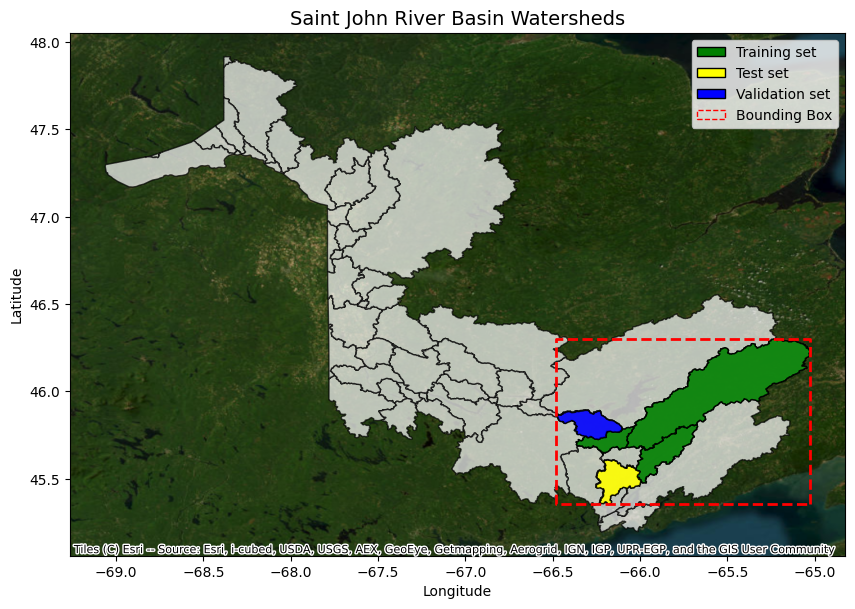

In [9]:
from shapely.geometry import box

colors = {"Training set": "green", "Test set": "yellow", "Validation set": "blue"}

fig, ax = plt.subplots(figsize=(10,8))

watersheds_df.plot(ax=ax, color="white", edgecolor="black", alpha=0.7)

category_gdfs = {}

for label, names in groups.items():
    category_gdfs[label] = watersheds_df[watersheds_df["LEVL2_NAME"].isin(names)]
    category_gdfs[label].plot(ax=ax, color=colors[label], edgecolor="black", alpha=0.9, label=label)
    
selected_watersheds = watersheds_df[watersheds_df["LEVL2_NAME"].isin(sum(groups.values(), []))]
bbox_geom = box(*selected_watersheds.total_bounds)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs=watersheds_df.crs)

bbox_gdf.plot(ax=ax, edgecolor="red", linewidth=2, linestyle="dashed", facecolor="none", label="Bounding Box")

try:
    ctx.add_basemap(ax, crs=watersheds_df.crs, source=ctx.providers.Esri.WorldImagery)
except Exception as e:
    print(e)
    
legend_elements = [Patch(facecolor=colors[label], edgecolor="black", label=label) for label in groups]
legend_elements.append(Patch(facecolor="none", edgecolor="red", linestyle="dashed", label="Bounding Box"))
ax.legend(handles=legend_elements, loc="upper right")

ax.set_title("Saint John River Basin Watersheds", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [10]:
bbox_gdf.to_markdown()

'|    | geometry                                                                                                                                                                                                   |\n|---:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|\n|  0 | POLYGON ((-65.02731348998586 45.35376615520766, -65.02731348998586 46.300424795942845, -66.47857729919788 46.300424795942845, -66.47857729919788 45.35376615520766, -65.02731348998586 45.35376615520766)) |'

In [11]:
zip_url = "http://geonb.snb.ca/downloads/forest_soils/geonb_forestsoils-solsforestiers_shp.zip"
# zip_filename = "geonb_forest_soils.zip"
zip_filename = "geonb_forestsoils-solsforestiers_shp.zip"
extracted_folder = "geonb_forest_soils"

# response = requests.get(zip_url, stream=True)
# if response.status_code == 200:
#     with open(zip_filename, "wb") as file:
#         file.write(response.content)
#     print(f"Downloaded: {zip_filename}")
# else:
#     print("Failed to download file. Status Code:", response.status_code)
#     exit()
    
os.makedirs(extracted_folder, exist_ok=True)
with zipfile.ZipFile(zip_filename, "r") as zip_ref:
    zip_ref.extractall(extracted_folder)
print(f"Extracted files to: {extracted_folder}")

shapefile_path = None
for file in os.listdir(extracted_folder):
    if file.endswith(".shp"):
        shapefile_path = os.path.join(extracted_folder, file)
        break
        
if not shapefile_path:
    print("No shapefile found in the extracted folder.")
    exit()
    
forest_soil_gdf = gpd.read_file(shapefile_path)
print(f"Loaded {len(forest_soil_gdf)} records from {shapefile_path}")

Extracted files to: geonb_forest_soils
Loaded 393796 records from geonb_forest_soils\geonb_forestsoils-solsforestiers.shp


In [12]:
forest_soil_gdf = forest_soil_gdf.to_crs(epsg=4326)

bounding_box = box(-66.47857729919788, 45.35376615520766, -65.02731348998586, 46.300424795942845)

forest_soil_filtered = forest_soil_gdf[forest_soil_gdf.intersects(bounding_box)]
print(f"Filtered down to {len(forest_soil_filtered)} records within the bounding box.")

Filtered down to 63465 records within the bounding box.


In [13]:
forest_soil_filtered.head()

OBJECTID SOIL  DRAIN SLOPE ASPECT   SHAPE_Leng    SHAPE_Area  \
63554     63555   SN      2     A      3  1496.908847  107099.81890   
63555     63556   RE      4     B      2  1047.492578   47196.37030   
63556     63557   RE      5     A      3  1379.990008   42301.05000   
63557     63558   SN      2     C      2  1199.980007   29700.29995   
63558     63559   SN      2     C      2  1020.000000   27001.49990   

                                                geometry  
63554  POLYGON ((-66.46100 46.29167, -66.46094 46.291...  
63555  POLYGON ((-66.44939 46.28978, -66.44963 46.289...  
63556  POLYGON ((-66.44419 46.28411, -66.44419 46.284...  
63557  POLYGON ((-66.47690 46.28115, -66.47690 46.280...  
63558  POLYGON ((-66.47456 46.28115, -66.47456 46.280...

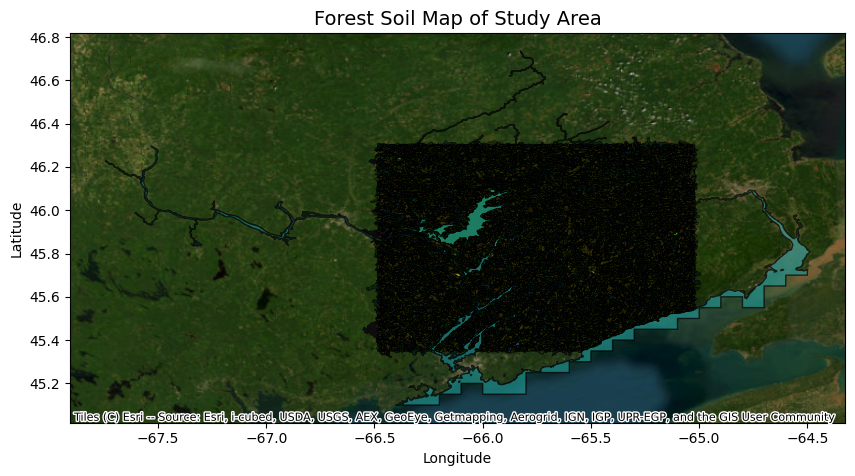

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
forest_soil_filtered.plot(ax=ax, cmap="viridis", edgecolor="black", alpha=0.7)

ctx.add_basemap(ax, crs=forest_soil_filtered.crs, source=ctx.providers.Esri.WorldImagery)

ax.set_title("Forest Soil Map of Study Area", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

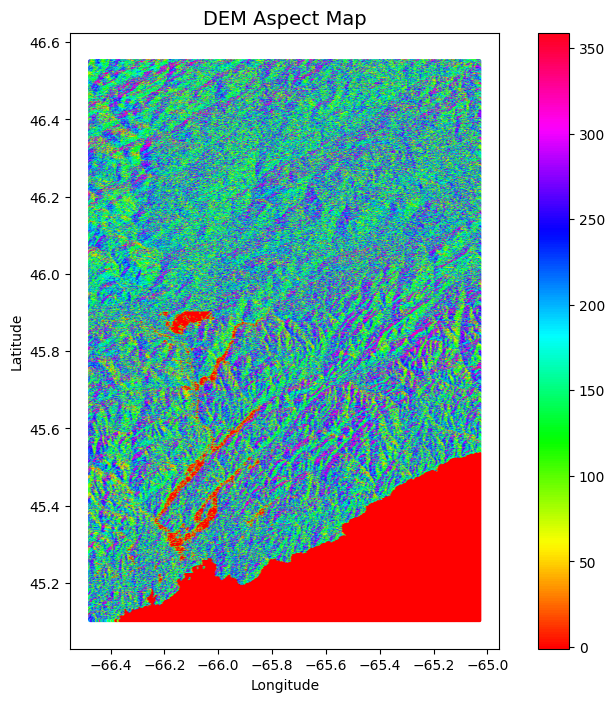

In [15]:
DEM_source_url = "https://geonb.snb.ca/image/rest/services/Elevation/DEM_Aspect_MNE_Aspect/ImageServer/exportImage"

bbox = "-66.47857729919788, 45.35376615520766, -65.02731348998586, 46.300424795942845"

params = {
    "bbox": bbox,
    "bboxSR": "4326",
    "size": "1024,1024",
    "imageSR": "4326",
    "format": "tiff",
    "f": "image"
}

response = requests.get(DEM_source_url, params=params, stream=True)

with MemoryFile(response.content) as memfile:
    with memfile.open() as src:
        dem_aspect_data = src.read(1)
        transform = src.transform
        crs = src.crs
        width, height = src.width, src.height
        
dem_points = []
for i in range(height):
    for j in range(width):
        lon, lat = xy(transform, i, j)
        aspect_value = dem_aspect_data[i, j]
        dem_points.append([lon, lat, aspect_value])
        
dem_df = gpd.GeoDataFrame(dem_points, columns=["Longitude", "Latitude", "Aspect"])
dem_df["geometry"] = gpd.points_from_xy(dem_df["Longitude"], dem_df["Latitude"])
dem_gdf = gpd.GeoDataFrame(dem_df, geometry="geometry", crs=crs)

fig, ax = plt.subplots(figsize=(10, 8))

dem_gdf.plot(ax=ax, column="Aspect", cmap="hsv", legend=True, markersize=1, alpha=0.7)

ax.set_title("DEM Aspect Map", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [16]:
dem_gdf

Longitude   Latitude      Aspect                    geometry
0       -66.477869  46.552019  255.188797  POINT (-66.47787 46.55202)
1       -66.476451  46.552019  223.878265  POINT (-66.47645 46.55202)
2       -66.475034  46.552019   47.679398  POINT (-66.47503 46.55202)
3       -66.473617  46.552019  189.491150  POINT (-66.47362 46.55202)
4       -66.472200  46.552019  113.327408  POINT (-66.47220 46.55202)
...            ...        ...         ...                         ...
1048571 -65.033691  45.102172    0.000000  POINT (-65.03369 45.10217)
1048572 -65.032274  45.102172    0.000000  POINT (-65.03227 45.10217)
1048573 -65.030857  45.102172    0.000000  POINT (-65.03086 45.10217)
1048574 -65.029439  45.102172    0.000000  POINT (-65.02944 45.10217)
1048575 -65.028022  45.102172    0.000000  POINT (-65.02802 45.10217)

[1048576 rows x 4 columns]

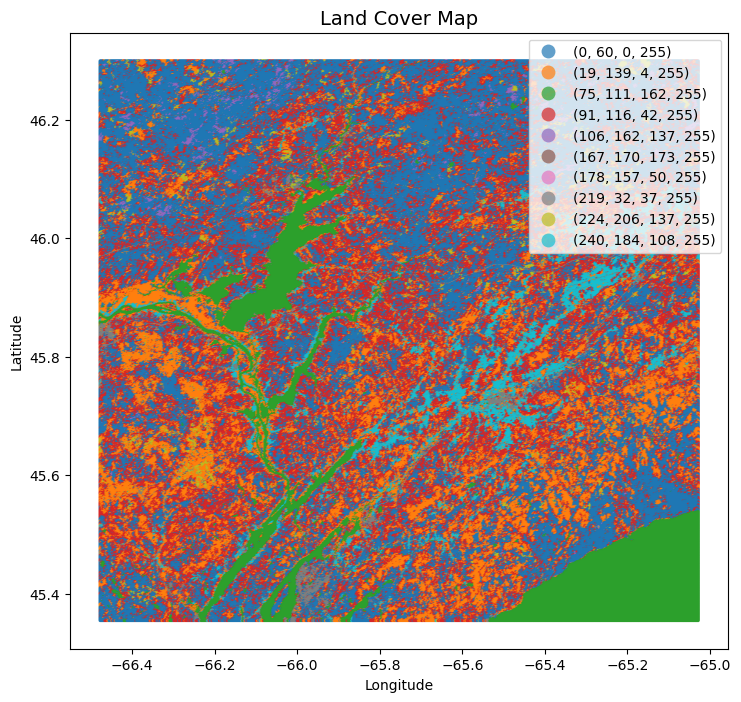

In [17]:
wms_url = "https://datacube.services.geo.ca/ows/landcover?"
wms = WebMapService(wms_url, version="1.3.0")

layer_name = "landcover-2015"
map_src = "EPSG:4326"

bbox_4326 = (-66.47857729919788, 45.35376615520766, -65.02731348998586, 46.300424795942845)

image_size = (1024, 768)

getmap_request = wms.getmap(
    layers=[layer_name],
    srs=map_src,
    bbox=bbox_4326,
    size=image_size,
    format="image/png",
    transparent=True
)

image_data = getmap_request.read()
img_landcover = PILImage.open(io.BytesIO(image_data))
land_cover_array = np.array(img_landcover)

'''Generating a geospatial transform which is needed to map pixel coordinates  to real world geographic coordinates'''

xmin, ymin, xmax, ymax = bbox_4326
transform = from_bounds(xmin, ymin, xmax, ymax, image_size[0], image_size[1])

points = []
for i in range(image_size[1]):
    for j in range(image_size[0]):
        lon, lat = rasterio.transform.xy(transform, i, j)
        rgba_value = tuple(land_cover_array[i,j])
        points.append([lon, lat, rgba_value])
        
landcover_gdf = gpd.GeoDataFrame(points, columns=["Longitude", "Latitude", "RGBA"])
landcover_gdf["geometry"] = gpd.points_from_xy(landcover_gdf["Longitude"], landcover_gdf["Latitude"])
landcover_gdf = gpd.GeoDataFrame(landcover_gdf, geometry="geometry", crs=map_src)

fig, ax = plt.subplots(figsize=(12,8))
landcover_gdf.plot(ax=ax, column="RGBA", cmap="tab10", markersize=1, alpha=0.7, legend=True)

ax.set_title("Land Cover Map", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [18]:
flood_df.head(2)

class                        FEATURE_ID                             MD_ID  \
0      1  56a74cbadb8d4524941bd7f43f69b52b  d1b1d8a8fe48463aa8489b7798c46015   
1      2  1f347a2f4e87445180d7d843f0c40aea  466772ea732342aebd461886a2144d6d   

    AREA_HA    DATE_UTC  TIME_UTC       PERIM_M  \
0  70797.68  2019-04-27  22:25:14  4.644986e+06   
1  12696.88  2019-04-27  22:25:14  2.333779e+06   

                                            geometry  
0  MULTIPOLYGON (((-66.06400 45.24707, -66.06347 ...  
1  MULTIPOLYGON (((-66.10235 45.23573, -66.10228 ...

In [19]:
watersheds_df.head(2)

geometry  OBJECTID LEVL1_2_NO  \
0  POLYGON ((-65.99487 45.36793, -65.99503 45.369...         1      01-01   
1  POLYGON ((-66.25361 45.35100, -66.25481 45.350...         2      01-03   

               LEVL1_NAME               LEVL2_NAME   Shape_Length  \
0  Saint John River Basin      Grand Bay Composite  121599.604617   
1  Saint John River Basin  Milkish Creek Composite   83301.942970   

     Shape_Area  
0  2.440396e+08  
1  1.345083e+08

In [20]:
forest_soil_filtered.head(2)

OBJECTID SOIL  DRAIN SLOPE ASPECT   SHAPE_Leng   SHAPE_Area  \
63554     63555   SN      2     A      3  1496.908847  107099.8189   
63555     63556   RE      4     B      2  1047.492578   47196.3703   

                                                geometry  
63554  POLYGON ((-66.46100 46.29167, -66.46094 46.291...  
63555  POLYGON ((-66.44939 46.28978, -66.44963 46.289...

In [21]:
landcover_gdf.head(2)

Longitude   Latitude             RGBA                    geometry
0 -66.477869  46.299808  (0, 60, 0, 255)  POINT (-66.47787 46.29981)
1 -66.476451  46.299808  (0, 60, 0, 255)  POINT (-66.47645 46.29981)

In [22]:
dem_gdf.head(2)

Longitude   Latitude      Aspect                    geometry
0 -66.477869  46.552019  255.188797  POINT (-66.47787 46.55202)
1 -66.476451  46.552019  223.878265  POINT (-66.47645 46.55202)

In [23]:
target_crs = "EPSG:4326"
landcover_gdf = landcover_gdf.to_crs(target_crs)
forest_soil_filtered = forest_soil_filtered.to_crs(target_crs)
watersheds_df = watersheds_df.to_crs(target_crs)
flood_df = flood_df.to_crs(target_crs)

merged_gdf = landcover_gdf.sjoin(forest_soil_filtered[["SOIL", "DRAIN", "SLOPE", "ASPECT", "geometry"]], how="left")

if "index_right" in merged_gdf.columns:
    merged_gdf.drop(columns=["index_right"], inplace=True)
    
merged_gdf = merged_gdf.sjoin(watersheds_df[["LEVL1_NAME", "LEVL2_NAME", "geometry"]], how="left")

if "index_right" in merged_gdf.columns:
    merged_gdf.drop(columns=["index_right"], inplace=True)
    
merged_gdf = merged_gdf.sjoin(flood_df[["geometry"]], how="left", predicate="within")
merged_gdf["Flooded"] = merged_gdf["index_right"].notna().astype(int)

merged_gdf.drop(columns=["index_right"], inplace=True)
merged_gdf.head()

Longitude   Latitude             RGBA                    geometry SOIL  \
0 -66.477869  46.299808  (0, 60, 0, 255)  POINT (-66.47787 46.29981)   RE   
1 -66.476451  46.299808  (0, 60, 0, 255)  POINT (-66.47645 46.29981)   RE   
2 -66.475034  46.299808  (0, 60, 0, 255)  POINT (-66.47503 46.29981)   RE   
3 -66.473617  46.299808  (0, 60, 0, 255)  POINT (-66.47362 46.29981)   RE   
4 -66.472200  46.299808  (0, 60, 0, 255)  POINT (-66.47220 46.29981)   RE   

   DRAIN SLOPE ASPECT              LEVL1_NAME      LEVL2_NAME  Flooded  
0    5.0     B      3  Saint John River Basin  Nashwaak River        0  
1    3.0     B      3  Saint John River Basin  Nashwaak River        0  
2    3.0     B      3  Saint John River Basin  Nashwaak River        0  
3    3.0     B      3  Saint John River Basin  Nashwaak River        0  
4    3.0     B      3  Saint John River Basin  Nashwaak River        0

In [25]:
merged_gdf.to_csv("merged_gdf.csv")

In [24]:
merged_gdf.Flooded.value_counts()

Flooded
0    738806
1     47626
Name: count, dtype: int64

In [25]:
merged_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 786432 entries, 0 to 786431
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Longitude   786432 non-null  float64 
 1   Latitude    786432 non-null  float64 
 2   RGBA        786432 non-null  object  
 3   geometry    786432 non-null  geometry
 4   SOIL        766664 non-null  object  
 5   DRAIN       766667 non-null  float64 
 6   SLOPE       718913 non-null  object  
 7   ASPECT      718913 non-null  object  
 8   LEVL1_NAME  619920 non-null  object  
 9   LEVL2_NAME  619920 non-null  object  
 10  Flooded     786432 non-null  int32   
dtypes: float64(3), geometry(1), int32(1), object(6)
memory usage: 69.0+ MB


In [26]:
merged_gdf.ASPECT.value_counts()

ASPECT
3    461144
2    132548
1    125221
Name: count, dtype: int64

In [27]:
Merged_Total = merged_gdf.copy()
Merged_Total.dropna(inplace=True)

In [28]:
Merged_Total.head(2)

Longitude   Latitude             RGBA                    geometry SOIL  \
0 -66.477869  46.299808  (0, 60, 0, 255)  POINT (-66.47787 46.29981)   RE   
1 -66.476451  46.299808  (0, 60, 0, 255)  POINT (-66.47645 46.29981)   RE   

   DRAIN SLOPE ASPECT              LEVL1_NAME      LEVL2_NAME  Flooded  
0    5.0     B      3  Saint John River Basin  Nashwaak River        0  
1    3.0     B      3  Saint John River Basin  Nashwaak River        0

In [31]:
'''Mgterged_Total.to_csv("Merged_Total.csv")'''

'Mgterged_Total.to_csv("Merged_Total.csv")'

In [29]:
for col in Merged_Total.columns:
    if Merged_Total[col].dtype == "object":
        print(col, Merged_Total[col].unique())

RGBA [(0, 60, 0, 255) (91, 116, 42, 255) (224, 206, 137, 255) (19, 139, 4, 255)
 (106, 162, 137, 255) (75, 111, 162, 255) (219, 32, 37, 255)
 (240, 184, 108, 255) (178, 157, 50, 255) (167, 170, 173, 255)]
SOIL ['RE' 'OS' 'SN' 'HT' 'SB' 'FA' 'RI' 'GG' 'IN' 'BB' 'SA' 'MD' 'PR' 'PT'
 'CH' 'KN' 'EB' 'SS' 'BR' 'JR' 'TR' 'BE' 'LO' 'TD' 'IR' 'MV' 'PD' 'LL'
 'KI' 'CT' 'TT' 'TH' 'GF' 'BD' 'JU' 'MG' 'CR' 'SP' 'HM' 'GE' 'TU' 'PI']
SLOPE ['B' 'A' 'C' 'D']
ASPECT ['3' '2' '1']
LEVL1_NAME ['Saint John River Basin']
LEVL2_NAME ['Nashwaak River' 'Jemseg River' 'Washademoak Creek' 'Kennebecasis River'
 'Swan Creek Composite' 'Baker Brook Composite' 'Oromocto River'
 'Belleisle Creek' 'Otnabog Stream Composite' 'Nerepis River'
 'Jones Brook Composite' 'Back Brook Composite' 'Milkish Creek Composite'
 'Grand Bay Composite']


In [30]:
new_data = Merged_Total.copy()

new_data = new_data[new_data["LEVL2_NAME"].str.contains("Washademoak Creek|Otnabog Stream Composite|Belleisle Creek", regex=True)]

In [31]:
Training_Set = Merged_Total[(Merged_Total["LEVL2_NAME"] == "Washademoak Creek") | (Merged_Total["LEVL2_NAME"] == "Otnabog Stream Composite") | (Merged_Total["LEVL2_NAME"] == "Belleisle Creek")]

Test_Set = Merged_Total[(Merged_Total["LEVL2_NAME"] == "Back Brook Composite")]

Validation_Set = Merged_Total[(Merged_Total["LEVL2_NAME"] == "Swan Creek Composite")]

In [32]:
Training_Set.head(2)

Longitude   Latitude                  RGBA                    geometry  \
877 -65.234941  46.299808    (91, 116, 42, 255)  POINT (-65.23494 46.29981)   
878 -65.233523  46.299808  (224, 206, 137, 255)  POINT (-65.23352 46.29981)   

    SOIL  DRAIN SLOPE ASPECT              LEVL1_NAME         LEVL2_NAME  \
877   HT    3.0     B      3  Saint John River Basin  Washademoak Creek   
878   HT    5.0     A      3  Saint John River Basin  Washademoak Creek   

     Flooded  
877        0  
878        0

In [33]:
Test_Set.head(2)

Longitude   Latitude                RGBA                    geometry  \
573644 -66.188750  45.609537  (219, 32, 37, 255)  POINT (-66.18875 45.60954)   
573645 -66.187332  45.609537  (219, 32, 37, 255)  POINT (-66.18733 45.60954)   

       SOIL  DRAIN SLOPE ASPECT              LEVL1_NAME            LEVL2_NAME  \
573644   PT    2.0     C      3  Saint John River Basin  Back Brook Composite   
573645   PT    2.0     B      1  Saint John River Basin  Back Brook Composite   

        Flooded  
573644        0  
573645        0

In [34]:
Validation_Set.head(2)

Longitude   Latitude               RGBA                    geometry  \
337011 -66.314885  45.894274  (19, 139, 4, 255)  POINT (-66.31488 45.89427)   
337012 -66.313468  45.894274  (19, 139, 4, 255)  POINT (-66.31347 45.89427)   

       SOIL  DRAIN SLOPE ASPECT              LEVL1_NAME            LEVL2_NAME  \
337011   IN    4.0     A      3  Saint John River Basin  Swan Creek Composite   
337012   IN    4.0     B      3  Saint John River Basin  Swan Creek Composite   

        Flooded  
337011        1  
337012        1

In [35]:
from sklearn.preprocessing import LabelEncoder
Training_Set['SLOPE'] = LabelEncoder().fit_transform(Training_Set['SLOPE'])
Test_Set['SLOPE'] = LabelEncoder().fit_transform(Test_Set['SLOPE'])
Validation_Set['SLOPE'] = LabelEncoder().fit_transform(Validation_Set['SOIL'])

Training_Set['SOIL'] = LabelEncoder().fit_transform(Training_Set['SOIL'])
Test_Set['SOIL'] = LabelEncoder().fit_transform(Test_Set['SOIL'])
Validation_Set['SOIL'] = LabelEncoder().fit_transform(Validation_Set['SOIL'])

In [36]:
Training_Set.head(2)

Longitude   Latitude                  RGBA                    geometry  \
877 -65.234941  46.299808    (91, 116, 42, 255)  POINT (-65.23494 46.29981)   
878 -65.233523  46.299808  (224, 206, 137, 255)  POINT (-65.23352 46.29981)   

     SOIL  DRAIN  SLOPE ASPECT              LEVL1_NAME         LEVL2_NAME  \
877     6    3.0      1      3  Saint John River Basin  Washademoak Creek   
878     6    5.0      0      3  Saint John River Basin  Washademoak Creek   

     Flooded  
877        0  
878        0

In [37]:
select_features = ['SOIL', 'DRAIN', 'SLOPE', 'ASPECT']

In [38]:
x_train = Training_Set[select_features]
y_train = Training_Set['Flooded']

x_test = Test_Set[select_features]
y_test = Test_Set['Flooded']

In [39]:
x_test.head()

SOIL  DRAIN  SLOPE ASPECT
573644    17    2.0      2      3
573645    17    2.0      1      1
573648    17    2.0      1      2
573649    17    2.0      1      2
574658    17    4.0      2      3

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [41]:
scaler = StandardScaler()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors=5)
nb = GaussianNB()
dt = DecisionTreeClassifier(max_depth=7)
rf = RandomForestClassifier()

models = {'SVC': svc, 'KNN': knn, 'Naive Bayes': nb, 'Decision Tree': dt, 'Random Forest': rf}

In [42]:
from sklearn.model_selection import GridSearchCV

param_grids = {
    "Random Forest": {
        "n_estimators": [50,100,200],
        "max_depth": [None,10,20],
        "min_samples_split": [2,5,10]
    },
    "Decision Tree": {
        "max_depth": [None,5,10,20],
        "min_samples_split": [2,5,10]
    },
    "KNN": {
        "n_neighbors": [3,5,7,10],
        "weights": ["uniform","distance"]
    },
}

best_models = {}

for name,param_grid in param_grids.items():
    model = models[name]
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(x_train, y_train)
    
    best_models[name] = {
        "Best Model": grid_search.best_estimator_,
        "Best Parameters": grid_search.best_params_,
        "Best Accuracy": grid_search.best_score_
    
    
    }
    
    print(f"\n{name} Best Parameters: {grid_search.best_params_}")
    print(f"Best Accuracy: {grid_search.best_score_:.4f}")


Random Forest Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best Accuracy: 0.9775

Decision Tree Best Parameters: {'max_depth': 5, 'min_samples_split': 2}
Best Accuracy: 0.9760

KNN Best Parameters: {'n_neighbors': 10, 'weights': 'uniform'}
Best Accuracy: 0.9798


In [43]:
scaler = StandardScaler()

knn = KNeighborsClassifier(n_neighbors = 10, weights = 'uniform')
dt = DecisionTreeClassifier(max_depth = 5, min_samples_split = 2)
rf = RandomForestClassifier(max_depth = 10, min_samples_split = 10, n_estimators = 50)

models = {'KNN': knn, 'Decision Tree': dt, 'Random Forest': rf}

In [44]:
for name, model in models.items():
    kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
    print(f"{name} : {cv_results.mean()} ({cv_results.std()})")
    model.fit(x_train, y_train)
    model.score(x_test, y_test)
    print(f"{name} Training Score : {model.score(x_test, y_test)}")
    
choice_model = nb.fit(x_train, y_train)

KNN : 0.9887050022623611 (2.112501029706178e-05)
KNN Training Score : 0.9876796714579056
Decision Tree : 0.9887106526183336 (1.3788847473358622e-05)
Decision Tree Training Score : 0.9876796714579056
Random Forest : 0.9887728057358899 (0.00015843867336424062)
Random Forest Training Score : 0.9846875916691111


In [45]:
results_test = []

for name, model in models.items():
    model.predict(x_test)
    model.score(x_test, y_test)
    
    results_test.append(
        {"Model": name,
        "Testing Score": model.score(x_test, y_test),
        "F1 Score": f1_score(y_test, model.predict(x_test)),
        "precision": precision_score(y_test, model.predict(x_test)),
        "recall": recall_score(y_test, model.predict(x_test)),
        "roc_auc_score": roc_auc_score(y_test, model.predict(x_test))
        })
    
results_test_df = pd.DataFrame(results_test)
results_test_df

Model  Testing Score  F1 Score  precision  recall  roc_auc_score
0            KNN       0.987680       0.0        0.0     0.0       0.500000
1  Decision Tree       0.987680       0.0        0.0     0.0       0.500000
2  Random Forest       0.984688       0.0        0.0     0.0       0.498485

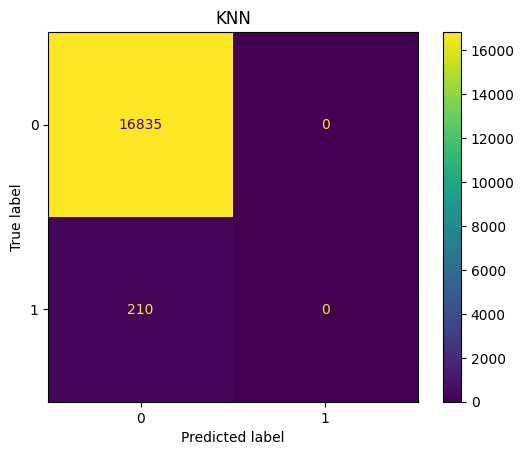

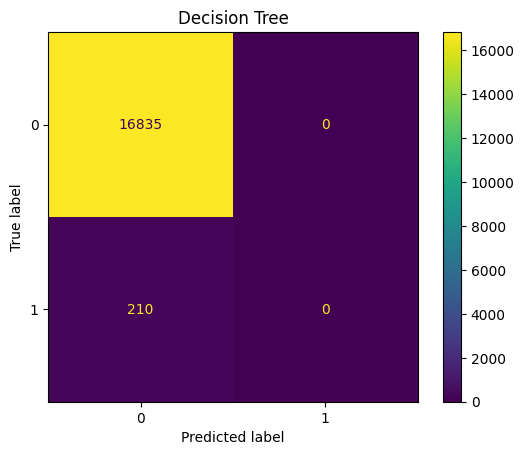

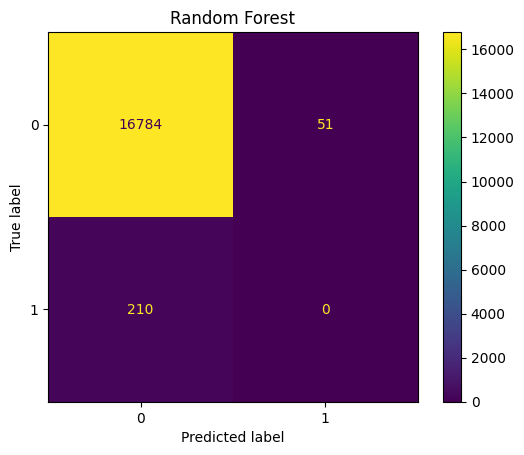

In [46]:
for name, model in models.items():
    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)
    plt.title(name)
    plt.show()

In [47]:
from sklearn.utils import resample
from collections import Counter 

df_majority = Training_Set[Training_Set["Flooded"] == 0]
df_minority = Training_Set[Training_Set["Flooded"] == 1]

print("Class distribution before downsampling:", Counter(Training_Set["Flooded"]))

df_majority_downsampled = resample(df_majority,
                                  replace=False,
                                  n_samples=len(df_minority),
                                  random_state=42)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

print("Class distribution after downsampling:", Counter(df_downsampled["Flooded"]))

Class distribution before downsampling: Counter({0: 174983, 1: 1998})
Class distribution after downsampling: Counter({0: 1998, 1: 1998})


In [48]:
x_train_sampled = df_downsampled[select_features]
y_train_sampled = df_downsampled['Flooded']

In [49]:
for name, model in models.items():
    model.fit(x_train_sampled, y_train_sampled)
    model.score(x_train_sampled, y_train_sampled)
    print(f"{name} Training Score : {model.score(x_train_sampled, y_train_sampled)}")

KNN Training Score : 0.6596596596596597
Decision Tree Training Score : 0.8105605605605606
Random Forest Training Score : 0.8648648648648649


In [50]:
results_sampled = []

for name, model in models.items():
    model.predict(x_test)
    model.score(x_test, y_test)
    results_sampled.append({
        "Model": name,
        "Testing Score": model.score(x_test, y_test),
        "F1_Score": f1_score(y_test, model.predict(x_test)),
        "precision": precision_score(y_test, model.predict(x_test)),
        "recall": recall_score(y_test, model.predict(x_test)),
        "roc_auc_score": roc_auc_score(y_test, model.predict(x_test))
        
    })
    

results_sampled_df = pd.DataFrame(results_sampled)
results_sampled_df

Model  Testing Score  F1_Score  precision    recall  roc_auc_score
0            KNN       0.846700  0.014334   0.007784  0.090476       0.473305
1  Decision Tree       0.655500  0.040209   0.020819  0.585714       0.621042
2  Random Forest       0.753593  0.048913   0.025678  0.514286       0.635432

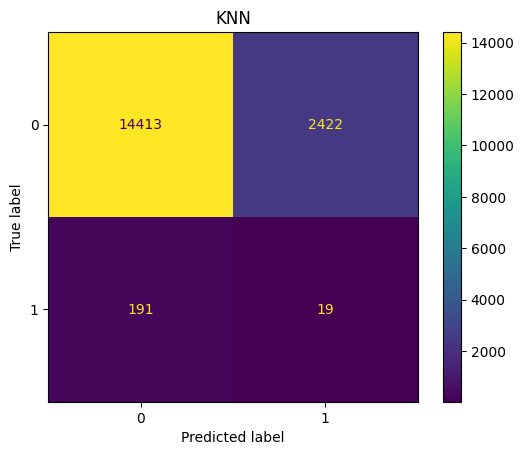

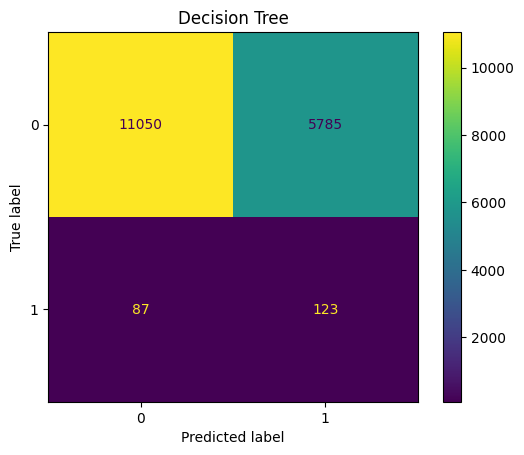

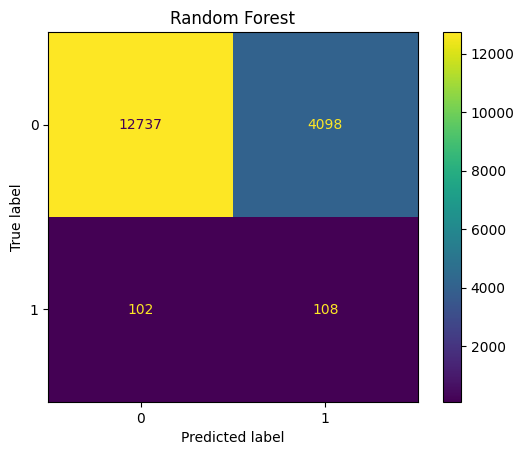

In [51]:
for name, model in models.items():
    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)
    plt.title(name)
    plt.show()

### Applying feature scaling 

In [52]:
x_train_scaled = pd.DataFrame( scaler.fit_transform(df_downsampled[select_features]), columns = df_downsampled[select_features].columns)
x_train_scaled.head()

SOIL     DRAIN     SLOPE    ASPECT
0  1.213375  0.359117 -1.062271  0.577764
1  1.213375  0.359117 -1.062271  0.577764
2 -1.795129 -0.778442  0.065175 -0.822324
3  1.036404 -0.209663  0.065175  0.577764
4 -1.087246 -0.209663  0.065175 -0.822324

In [53]:
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
x_test_scaled.head()

SOIL     DRAIN     SLOPE    ASPECT
0  0.859434 -1.347221  1.192622  0.577764
1  0.859434 -1.347221  0.065175 -2.222412
2  0.859434 -1.347221  0.065175 -0.822324
3  0.859434 -1.347221  0.065175 -0.822324
4  0.859434 -0.209663  1.192622  0.577764

In [54]:
for name, model in models.items():
    model.fit(x_train_scaled, y_train_sampled)
    print(f"{name} Training Score : {model.score(x_train_scaled, y_train_sampled)}")

KNN Training Score : 0.5873373373373373
Decision Tree Training Score : 0.8105605605605606
Random Forest Training Score : 0.8661161161161162


In [55]:
results_scaled = []

for name, model in models.items():
    model.predict(x_test_scaled)
    results_scaled.append({
        "Model": name,
        "Testing Score": model.score(x_test_scaled, y_test),
        "F1 Score": f1_score(y_test, model.predict(x_test_scaled)),
        "precision": precision_score(y_test, model.predict(x_test_scaled)),
        "recall": recall_score(y_test, model.predict(x_test_scaled))
    })
    
    
results_scaled_df = pd.DataFrame(results_scaled)
results_scaled_df

Model  Testing Score  F1 Score  precision    recall
0            KNN       0.888882  0.064229   0.035832  0.309524
1  Decision Tree       0.655500  0.040209   0.020819  0.585714
2  Random Forest       0.802640  0.060860   0.032325  0.519048

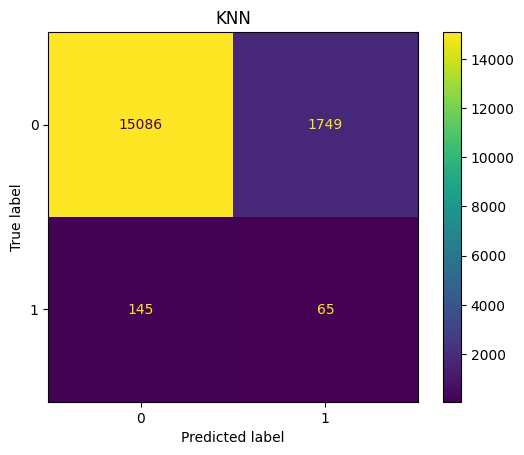

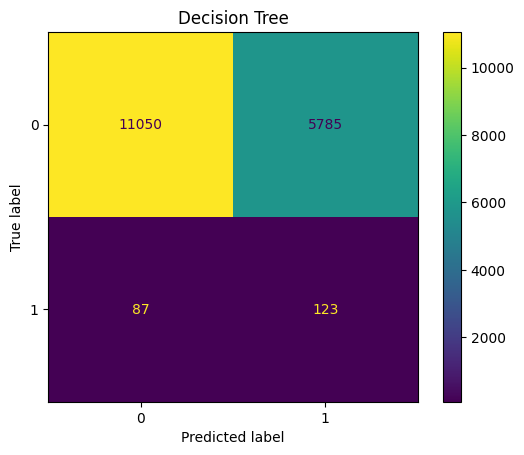

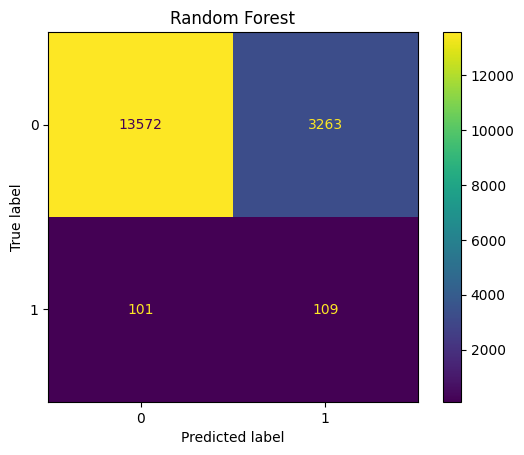

In [56]:
for name, model in models.items():
    ConfusionMatrixDisplay.from_estimator(model, x_test_scaled, y_test)
    plt.title(name)
    plt.show()

In [57]:
results_scaled_df, results_sampled_df, results_test_df

(           Model  Testing Score  F1 Score  precision    recall
 0            KNN       0.888882  0.064229   0.035832  0.309524
 1  Decision Tree       0.655500  0.040209   0.020819  0.585714
 2  Random Forest       0.802640  0.060860   0.032325  0.519048,
            Model  Testing Score  F1_Score  precision    recall  roc_auc_score
 0            KNN       0.846700  0.014334   0.007784  0.090476       0.473305
 1  Decision Tree       0.655500  0.040209   0.020819  0.585714       0.621042
 2  Random Forest       0.753593  0.048913   0.025678  0.514286       0.635432,
            Model  Testing Score  F1 Score  precision  recall  roc_auc_score
 0            KNN       0.987680       0.0        0.0     0.0       0.500000
 1  Decision Tree       0.987680       0.0        0.0     0.0       0.500000
 2  Random Forest       0.984688       0.0        0.0     0.0       0.498485)

### INTERPRETATION OF MODEL METRICS VALUES 

In [58]:
combined_results_df = pd.concat([results_scaled_df, results_sampled_df, results_test_df], keys=["Scaled", "Sampled", "Test"], names=["Dataset"])
combined_results_df.reset_index(level="Dataset", inplace=True)

combined_results_df

Dataset          Model  Testing Score  F1 Score  precision    recall  \
0   Scaled            KNN       0.888882  0.064229   0.035832  0.309524   
1   Scaled  Decision Tree       0.655500  0.040209   0.020819  0.585714   
2   Scaled  Random Forest       0.802640  0.060860   0.032325  0.519048   
0  Sampled            KNN       0.846700       NaN   0.007784  0.090476   
1  Sampled  Decision Tree       0.655500       NaN   0.020819  0.585714   
2  Sampled  Random Forest       0.753593       NaN   0.025678  0.514286   
0     Test            KNN       0.987680  0.000000   0.000000  0.000000   
1     Test  Decision Tree       0.987680  0.000000   0.000000  0.000000   
2     Test  Random Forest       0.984688  0.000000   0.000000  0.000000   

   F1_Score  roc_auc_score  
0       NaN            NaN  
1       NaN            NaN  
2       NaN            NaN  
0  0.014334       0.473305  
1  0.040209       0.621042  
2  0.048913       0.635432  
0       NaN       0.500000  
1       NaN       0.500000  
2       NaN       0.498485

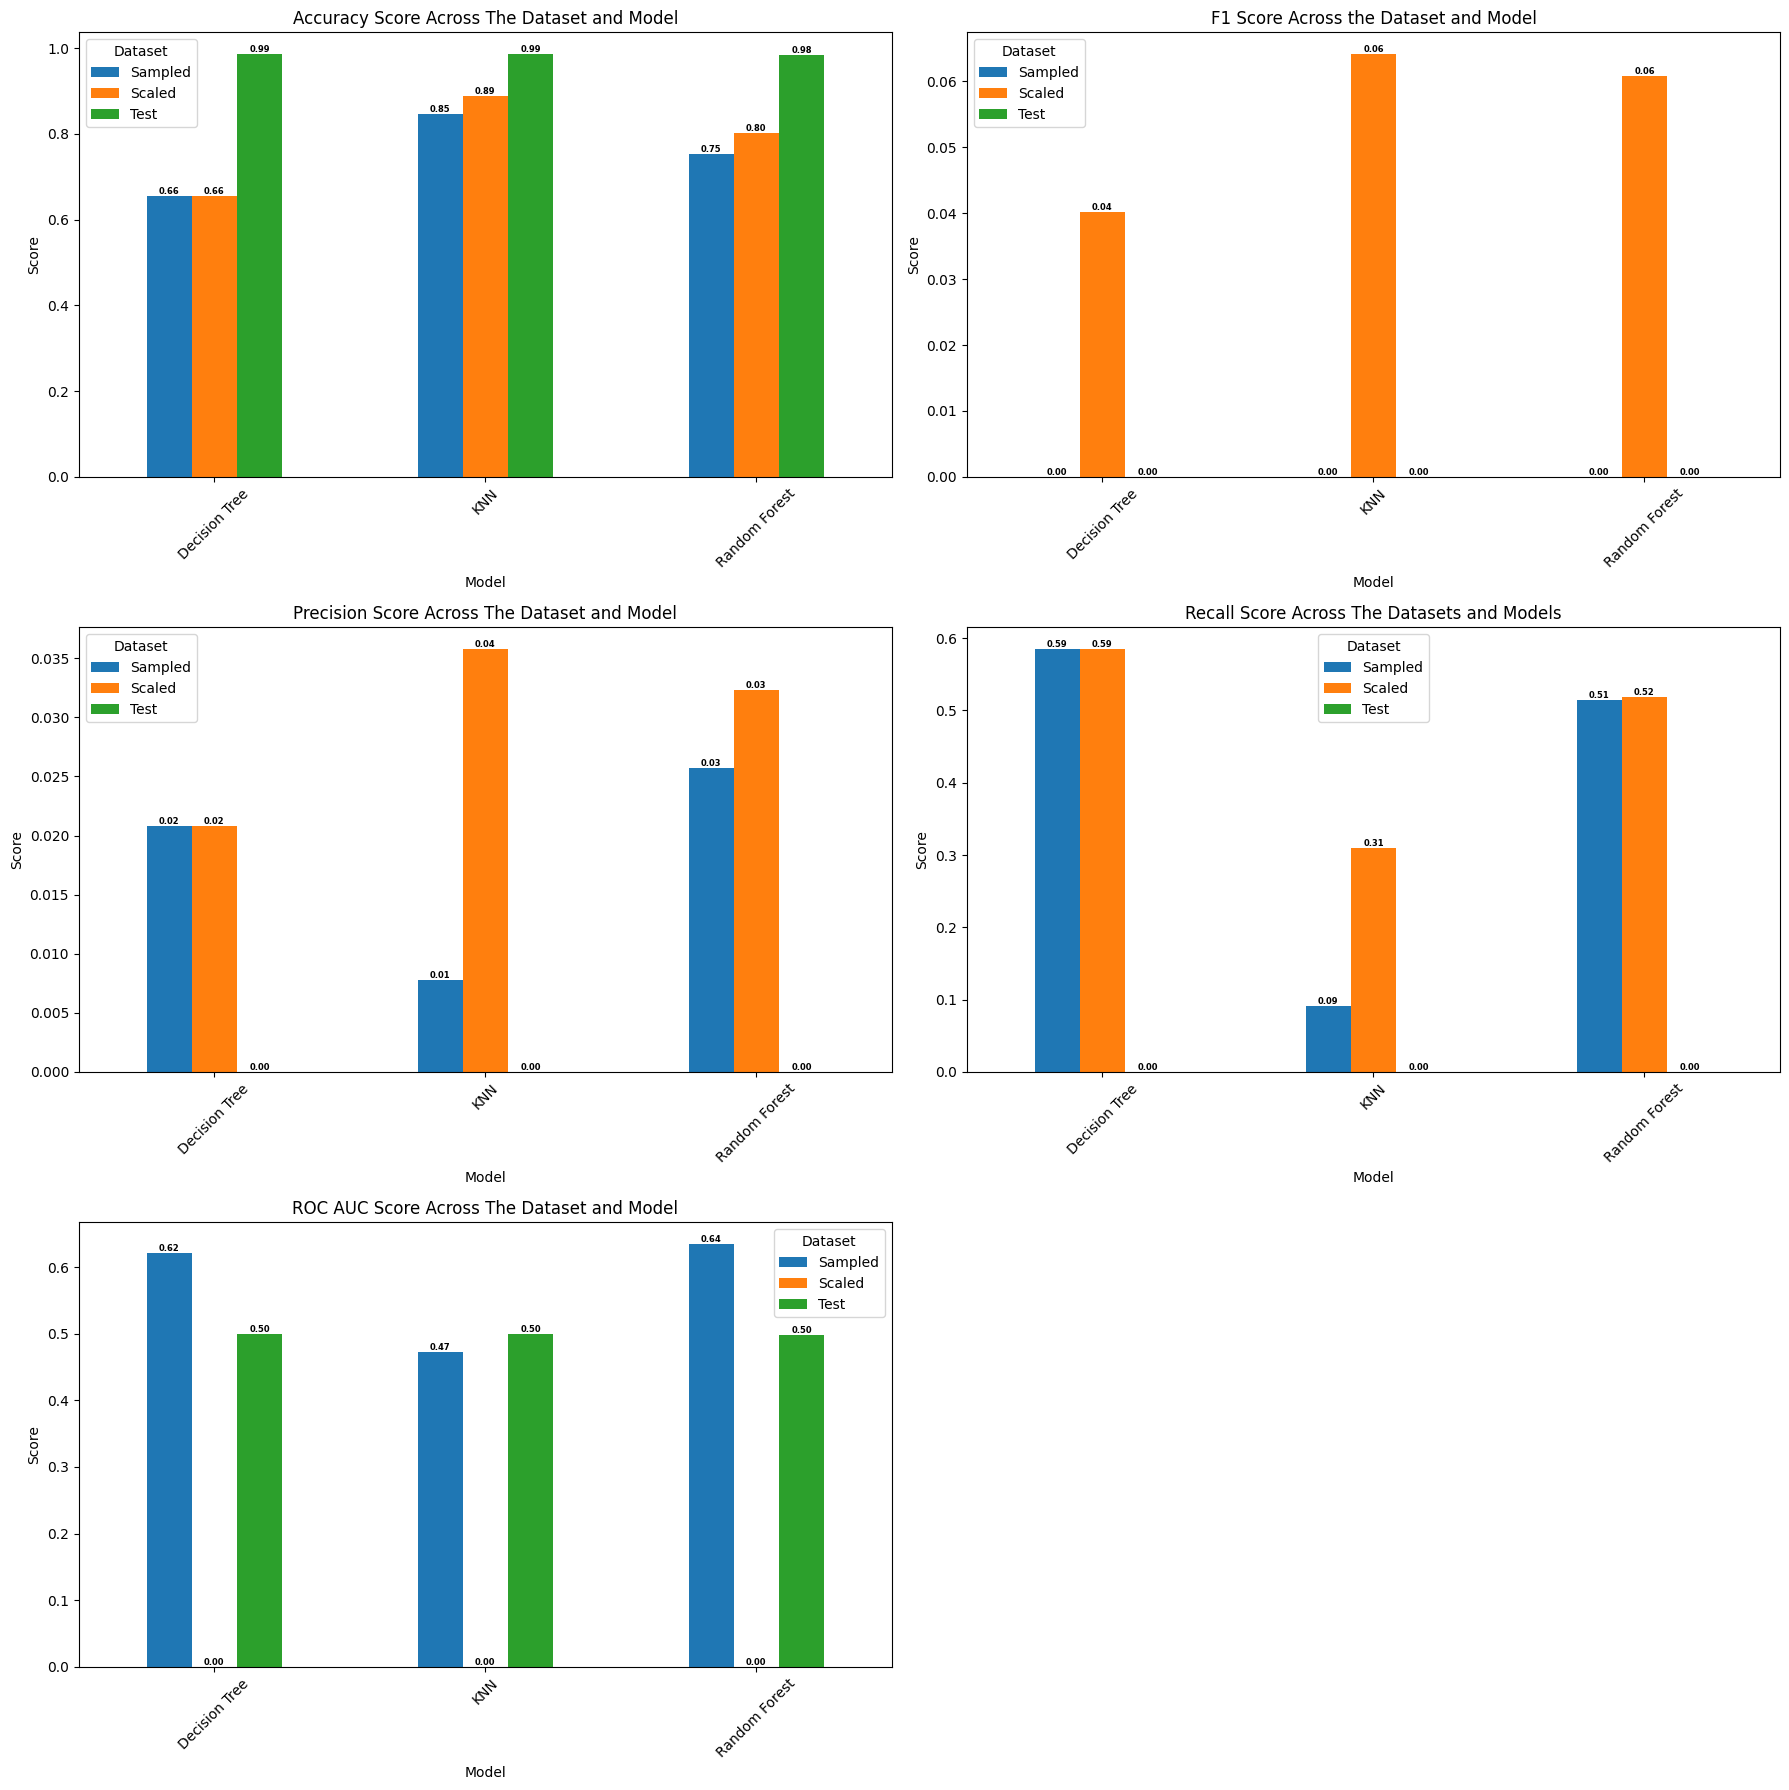

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,18))
def add_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{height:.2f}", (p.get_x() + p.get_width() / 2., height),
                   ha='center', va='bottom', fontsize=6, color='black', fontweight='bold')
        
ax1 = combined_results_df.pivot(index="Model", columns="Dataset", values="Testing Score").plot(kind="bar", ax=axes[0, 0])
axes[0, 0].set_title("Accuracy Score Across The Dataset and Model")
axes[0, 0].set_ylabel("Score")
axes[0, 0].set_xlabel("Model")
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend(title="Dataset")
add_labels(ax1)
        
# Plotting the F1 Score
ax2 = combined_results_df.pivot(index="Model", columns="Dataset", values="F1 Score").plot(kind="bar", ax=axes[0, 1])
axes[0, 1].set_title("F1 Score Across the Dataset and Model")
axes[0, 1].set_ylabel("Score")
axes[0, 1].set_xlabel("Model")
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].legend(title="Dataset")
add_labels(ax2)

# Plotting the Precision Score
ax3 = combined_results_df.pivot(index="Model", columns="Dataset", values="precision").plot(kind="bar", ax=axes[1, 0])
axes[1, 0].set_title("Precision Score Across The Dataset and Model")
axes[1, 0].set_ylabel("Score")
axes[1, 0].set_xlabel("Model")
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend(title="Dataset")
add_labels(ax3)

# Plotting the Recall Score
ax4 = combined_results_df.pivot(index="Model", columns="Dataset", values="recall").plot(kind="bar", ax=axes[1, 1])
axes[1, 1].set_title("Recall Score Across The Datasets and Models")
axes[1, 1].set_ylabel("Score")
axes[1, 1].set_xlabel("Model")
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend(title="Dataset")
add_labels(ax4)

# Plotting the ROC AUC Score
roc_auc_df = combined_results_df.pivot(index="Model", columns="Dataset", values="roc_auc_score")
ax5 = roc_auc_df.plot(kind="bar", ax=axes[2, 0])
axes[2, 0].set_title("ROC AUC Score Across The Dataset and Model")
axes[2, 0].set_ylabel("Score")
axes[2, 0].set_xlabel("Model")
axes[2, 0].tick_params(axis='x', rotation=45)
axes[2, 0].legend(title="Dataset")
add_labels(ax5)

axes[2, 1].axis("off") #b Lets prevent the empty plot from displaying, since we just have 5 metrics to visualise, which isn't even

plt.tight_layout()
plt.show()

In [60]:
Test_Set['predicted'] = knn.predict(x_test)

In [61]:
Test_Set.predicted.value_counts()

predicted
0    15148
1     1897
Name: count, dtype: int64

In [62]:
Test_Set.head()

Longitude   Latitude                  RGBA  \
573644 -66.188750  45.609537    (219, 32, 37, 255)   
573645 -66.187332  45.609537    (219, 32, 37, 255)   
573648 -66.183081  45.609537  (224, 206, 137, 255)   
573649 -66.181663  45.609537    (91, 116, 42, 255)   
574658 -66.202922  45.608304     (19, 139, 4, 255)   

                          geometry  SOIL  DRAIN  SLOPE ASPECT  \
573644  POINT (-66.18875 45.60954)    17    2.0      2      3   
573645  POINT (-66.18733 45.60954)    17    2.0      1      1   
573648  POINT (-66.18308 45.60954)    17    2.0      1      2   
573649  POINT (-66.18166 45.60954)    17    2.0      1      2   
574658  POINT (-66.20292 45.60830)    17    4.0      2      3   

                    LEVL1_NAME            LEVL2_NAME  Flooded  predicted  
573644  Saint John River Basin  Back Brook Composite        0          0  
573645  Saint John River Basin  Back Brook Composite        0          0  
573648  Saint John River Basin  Back Brook Composite        0          0  
573649  Saint John River Basin  Back Brook Composite        0          0  
574658  Saint John River Basin  Back Brook Composite        0          0

In [63]:
test_area = watersheds_df[watersheds_df["LEVL2_NAME"] == "Back Brook Composite"].geometry

In [64]:
flood_df.head()

class                        FEATURE_ID                             MD_ID  \
0      1  56a74cbadb8d4524941bd7f43f69b52b  d1b1d8a8fe48463aa8489b7798c46015   
1      2  1f347a2f4e87445180d7d843f0c40aea  466772ea732342aebd461886a2144d6d   
2      3  6fc76581c00f4002b38b8b6d89b4bc2b  164461d57ca345d5adb2f8f93f9f4dd7   

    AREA_HA    DATE_UTC  TIME_UTC       PERIM_M  \
0  70797.68  2019-04-27  22:25:14  4.644986e+06   
1  12696.88  2019-04-27  22:25:14  2.333779e+06   
2  21819.22  2019-04-27  22:25:14  3.755311e+06   

                                            geometry  
0  MULTIPOLYGON (((-66.06400 45.24707, -66.06347 ...  
1  MULTIPOLYGON (((-66.10235 45.23573, -66.10228 ...  
2  MULTIPOLYGON (((-66.10238 45.23576, -66.10236 ...

In [65]:
clipped_test_area = gpd.clip(flood_df,test_area)

<Axes: >

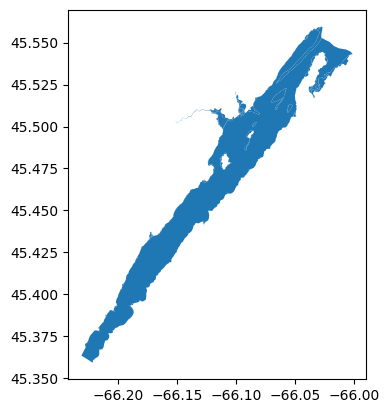

In [66]:
clipped_test_area.plot()

In [67]:
x_test.head()

SOIL  DRAIN  SLOPE ASPECT
573644    17    2.0      2      3
573645    17    2.0      1      1
573648    17    2.0      1      2
573649    17    2.0      1      2
574658    17    4.0      2      3

In [78]:
x_test['Actual'] = y_test

In [81]:
Test_Set['predicted'] = choice_model.predict(x_test.drop(["Actual"], axis=1))

In [68]:
Test_Set.head(2)

Longitude   Latitude                RGBA                    geometry  \
573644 -66.188750  45.609537  (219, 32, 37, 255)  POINT (-66.18875 45.60954)   
573645 -66.187332  45.609537  (219, 32, 37, 255)  POINT (-66.18733 45.60954)   

        SOIL  DRAIN  SLOPE ASPECT              LEVL1_NAME  \
573644    17    2.0      2      3  Saint John River Basin   
573645    17    2.0      1      1  Saint John River Basin   

                  LEVL2_NAME  Flooded  predicted  
573644  Back Brook Composite        0          0  
573645  Back Brook Composite        0          0

### Running The Model Using An Unseen Data 

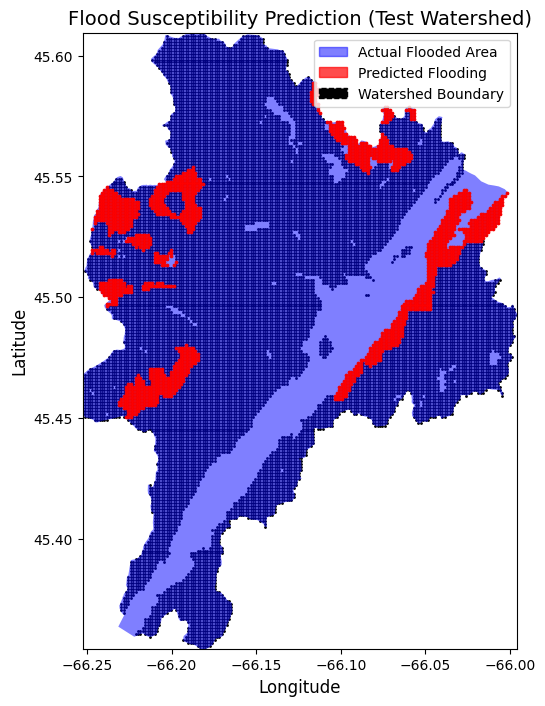

In [71]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(10,8))

minx, miny, maxx, maxy = Test_Set.total_bounds
ax.set_xlim(minx,maxx)
ax.set_ylim(miny,maxy)

Test_Set.plot(ax=ax, color="black", markersize=1)

test_area.plot(ax=ax, color="blue", alpha=0.5)

predicted_flood = Test_Set[Test_Set["predicted"] == 1]

if not predicted_flood.empty:
    predicted_flood.plot(ax=ax, color="red", markersize=3, alpha=0.9)
else:
    print("No predicted flooded areas to plot.")

legend_handles = [
    mpatches.Patch(color="blue", alpha=0.5, label="Actual Flooded Area"),
    mpatches.Patch(color="red", alpha=0.7, label="Predicted Flooding"),
    mpatches.Patch(color="black", linestyle="dashed", linewidth=1, label="Watershed Boundary")
]

ax.legend(handles=legend_handles, loc="upper right")

ax.set_title("Flood Susceptibility Prediction (Test Watershed)", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

plt.savefig("flood_susceptibility_prediction_saint_john.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
Target_watershed = watersheds_df[watersheds_df["LEVL2_NAME"] == 'Swan Creek Composite']

In [ ]:
Target_watershed_geometry = Target_watershed.geometry
flood_df_clip = gpd.clip(flood_df, Target_watershed_geometry)
soil_df_clip = gpd.clip(forest_soil_filtered  , Target_watershed_geometry)

result_bbox = Target_watershed_geometry.total_bounds

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches

# Ensure geometries are valid
merged_gdf = merged_gdf[~merged_gdf.boundary.is_empty]
dem_gdf = dem_gdf[~dem_gdf.geometry.is_empty]

# Ensure CRS consistency
if merged_gdf.crs is None:
    merged_gdf = merged_gdf.set_crs("EPSG:4326")

if dem_gdf.crs is None:
    dem_gdf = dem_gdf.set_crs("EPSG:4326")

if merged_gdf.crs != dem_gdf.crs:
    merged_gdf = merged_gdf.to_crs(dem_gdf.crs)

# Clip flood areas to test watershed
Test_Set = merged_gdf[merged_gdf["LEVL2_NAME"] == 'Swan Creek Composite'].geometry.dropna()
flood_gdf_clipped = gpd.clip(dem_gdf, Test_Set)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Get bounding box of test watershed
if not Test_Set.empty:
    minx, miny, maxx, maxy = Test_Set.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

# Set aspect ratio manually
ax.set_aspect('auto')

# Test watershed boundary
merged_gdf.boundary.plot(ax=ax, color="black", linestyle="dashed", linewidth=1)

# Actual flood areas (blue)
flood_gdf_clipped.plot(ax=ax, color="blue", alpha=0.5)

# Predicted flooded points (red)
dem_gdf[dem_gdf["Flooded"] == 1].plot(ax=ax, color="red", markersize=3, alpha=0.7)

# Legend
legend_handles = [
    mpatches.Patch(color="blue", alpha=0.5, label="Actual Flooded Area"),
    mpatches.Patch(color="red", alpha=0.7, label="Predicted Flooding"),
    mpatches.Patch(color="black", linestyle="dashed", linewidth=1, label="Watershed Boundary")
]
ax.legend(handles=legend_handles, loc="upper right")

# Title & labels
ax.set_title("Flood Susceptibility Prediction (Test Watershed)", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

ax.set_aspect('auto')